In [1]:
import pandas as pd
import numpy as np

## 1. Get the list of songs and their peak positions on hot 100 chart from 2015 to 2016

In [50]:
import billboard

song_dict = {}
song_dict['name'] = []
song_dict['peak'] = []
chart = billboard.ChartData(name = 'hot-100', date = '2016-12-31')
while chart.previousDate:
    for track in chart:
        if track.title not in song_dict['name']:
            song_dict['name'].append(track.title)
            song_dict['peak'].append(track.peakPos)
    prevDate = chart.previousDate
    if int(prevDate.split('-')[0]) < 2016:
        break
    chart = billboard.ChartData('hot-100', prevDate)
    print(chart.previousDate)

2016-12-17
2016-12-10
2016-12-03
2016-11-26
2016-11-19
2016-11-12
2016-11-05
2016-10-29
2016-10-22
2016-10-15
2016-10-08
2016-10-01
2016-09-24
2016-09-17
2016-09-10
2016-09-03
2016-08-27
2016-08-20
2016-08-13
2016-08-06
2016-07-30
2016-07-23
2016-07-16
2016-07-09
2016-07-02
2016-06-25
2016-06-18
2016-06-11
2016-06-04
2016-05-28
2016-05-21
2016-05-14
2016-05-07
2016-04-30
2016-04-23
2016-04-16
2016-04-09
2016-04-02
2016-03-26
2016-03-19
2016-03-12
2016-03-05
2016-02-27
2016-02-20
2016-02-13
2016-02-06
2016-01-30
2016-01-23
2016-01-16
2016-01-09
2016-01-02
2015-12-26


## 2. Setup spotify API

In [69]:
import sys
import spotipy
import spotipy.util as util

User = 'Jade Chou'
Client_ID = 'cf668bfb160d4d518800653e2d7cb17d'
Client_Secret = '93acc85286104390a45fbfcbb2889e5f'
URL = 'http://localhost:8888/callback'
scope = 'user-read-private user-read-email'
token = util.prompt_for_user_token(User,scope, client_id=Client_ID,client_secret=Client_Secret,redirect_uri=URL)
sp = spotipy.Spotify(auth = token)

## 3. Extract audio features

In [52]:
import time

info_df = pd.DataFrame.from_dict(song_dict)
tracks = info_df['name']
drop_lst = []
def getID(tracks):
    tracksID = []
    for i, track in enumerate(tracks):
        if i > 0 and i % 100 == 0:
            print('finish %d songs!' % i)
            time.sleep(10)
        result = sp.search(q=track, type='track')
        try:
            trackID = result['tracks']['items'][0]['id']
            tracksID.append(trackID)
        except:
            print('Cannot find information about %s.' % track)
            drop_lst.append(i)
    return tracksID, drop_lst
tracksID, drop_lst = getID(tracks)
prev_drop = len(drop_lst)
new_info_df = info_df.drop(drop_lst)

num_song = int(np.ceil(len(tracksID)/100))
audiofeatures = []
for i in range(num_song):
    audiofeatures.append(sp.audio_features(tracksID[(100*i):(100*(i+1))]))
for lst in audiofeatures[1:]:
    audiofeatures[0].extend(lst)
tracksFeatures = audiofeatures[0]

retrying ...1secs
finish 100 songs!
retrying ...1secs
finish 200 songs!
finish 300 songs!
finish 400 songs!
Cannot find information about Untitled 02 l 06.23.2014..
Cannot find information about Untitled 07 l Levitate.
finish 500 songs!


In [53]:
# exception handling
for i, feat in enumerate(tracksFeatures):
    if feat is None:
        drop_lst.append(i)
final_info_df = new_info_df.drop(drop_lst[prev_drop:])

for i, idx in enumerate(drop_lst):
    if i >= prev_drop:
        del tracksFeatures[idx-(i-prev_drop)]

tracks_df = pd.DataFrame.from_dict(tracksFeatures)
tracks_df['name'] = np.array(final_info_df['name'])
tracks_df['peak'] = np.array(final_info_df['peak'])
tracks_df['hit'] = (tracks_df['peak'] <= 10).astype(int)
tracks_df.to_csv('tracks_2016.csv')

## 4. Build the model

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

tracks_df_3yr = pd.read_csv('tracks_up_2014-2016.csv')
tracks_df_2yr = pd.read_csv('tracks_up_2015-2016.csv')
tracks_df_1yr = pd.read_csv('tracks_up_2016.csv')

In [25]:
train_df_1 = pd.read_csv('tracks_up_2014.csv')
train_df_2_1 = pd.read_csv('tracks_up_2015.csv')
train_df_2_2 = pd.read_csv('tracks_up_2014-2015.csv')

test_df_1 = pd.read_csv('test_2015.csv')
test_df_2 = pd.read_csv('test_2016.csv')
test_df_3 = pd.read_csv('test_2017.csv')

### 1) Deal with missing values

In [26]:
np.sum(tracks_df_1yr.isnull(), 0)

Unnamed: 0          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
key                 0
time_signature      0
Class               0
dtype: int64

Since there are two songs with missing features, we can just delete these two songs.

### 2) Deal with unbalanced data - upsampling
Use "caret" package in R

### 3) Feature Selection - GBDT

In [27]:
tracks_df_up = tracks_df_1yr.sample(frac=1)
X = tracks_df_up[['acousticness', 'danceability', 'duration_ms', 'energy', 
                'instrumentalness', 'liveness', 'loudness', 'mode', 
                'speechiness', 'tempo', 'valence', 'key', 'time_signature']]
y = tracks_df_up['Class']
kf = KFold(n_splits=5)
kf.get_n_splits(X)
f1_lst = []
learning_lst = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
new_learning_lst = [0.5, 0.6, 0.7]
estimator_lst = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
new_estimator_lst = [80, 90, 100]
best_f1 = float('-inf')

#### (1) Leanring Rate

In [17]:
for rate in learning_lst:
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        gbdt = ensemble.GradientBoostingClassifier(learning_rate = rate)
        gbdt.fit(X_train, y_train)
        pred = gbdt.predict(X_test)
        f1 = f1_score(y_test, pred)
        f1_lst.append(f1)
    avg_f1 = np.mean(f1_lst)
    print('When learning_rate = %.1f F1: %.4f' % (rate, avg_f1))
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_rate = rate

When learning_rate = 0.0 F1: 0.7107
When learning_rate = 0.0 F1: 0.7728
When learning_rate = 0.1 F1: 0.8154
When learning_rate = 0.2 F1: 0.8405
When learning_rate = 0.3 F1: 0.8563
When learning_rate = 0.4 F1: 0.8643
When learning_rate = 0.5 F1: 0.8694
When learning_rate = 0.6 F1: 0.8743
When learning_rate = 0.7 F1: 0.8793
When learning_rate = 0.8 F1: 0.8817
When learning_rate = 0.9 F1: 0.8842
When learning_rate = 1.0 F1: 0.8840


#### (2) n_estimators

In [19]:
for n in estimator_lst:
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        gbdt = ensemble.GradientBoostingClassifier(n_estimators = n)
        gbdt.fit(X_train, y_train)
        pred = gbdt.predict(X_test)
        f1 = f1_score(y_test, pred)
        f1_lst.append(f1)
    avg_f1 = np.mean(f1_lst)
    print('When learning_rate = %.1f F1: %.4f' % (n, avg_f1))
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_estimator = n

When learning_rate = 10.0 F1: 0.7896
When learning_rate = 20.0 F1: 0.8248
When learning_rate = 30.0 F1: 0.8393
When learning_rate = 40.0 F1: 0.8484
When learning_rate = 50.0 F1: 0.8554
When learning_rate = 60.0 F1: 0.8625
When learning_rate = 70.0 F1: 0.8682
When learning_rate = 80.0 F1: 0.8720
When learning_rate = 90.0 F1: 0.8753
When learning_rate = 100.0 F1: 0.8784


#### (3) Tunning Together

In [20]:
best_f1 = float('-inf')
for n in new_estimator_lst:
    for rate in new_learning_lst:
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            gbdt = ensemble.GradientBoostingClassifier(n_estimators = n, learning_rate = rate)
            gbdt.fit(X_train, y_train)
            pred = gbdt.predict(X_test)
            f1 = f1_score(y_test, pred)
            f1_lst.append(f1)
        avg_f1 = np.mean(f1_lst)
        print('When learning_rate = %.1f n_estimators = %.1f, F1: %.4f' % (rate, n, avg_f1))
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_estimator = n
            best_rate = rate

When learning_rate = 0.5 n_estimators = 80.0, F1: 0.8802
When learning_rate = 0.6 n_estimators = 80.0, F1: 0.8799
When learning_rate = 0.7 n_estimators = 80.0, F1: 0.8805
When learning_rate = 0.5 n_estimators = 90.0, F1: 0.8818
When learning_rate = 0.6 n_estimators = 90.0, F1: 0.8815
When learning_rate = 0.7 n_estimators = 90.0, F1: 0.8823
When learning_rate = 0.5 n_estimators = 100.0, F1: 0.8830
When learning_rate = 0.6 n_estimators = 100.0, F1: 0.8835
When learning_rate = 0.7 n_estimators = 100.0, F1: 0.8839


In [28]:
gbdt = ensemble.GradientBoostingClassifier(learning_rate = 0.6, n_estimators = 90)
gbdt.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.6, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=90, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [30]:
tracks_df_up = pd.read_csv('tracks_up_2017.csv')
tracks_df_up = tracks_df_up.sample(frac=1)
X_test = tracks_df_up[['acousticness', 'danceability', 'duration_ms', 'energy', 
                'instrumentalness', 'liveness', 'loudness', 'mode', 
                'speechiness', 'tempo', 'valence', 'key', 'time_signature']]
y_test = tracks_df_up['Class']
y_pred = gbdt.predict(X_test)
f1 = f1_score(y_test, y_pred)
print('F1: %.4f' % f1)

F1: 0.1364


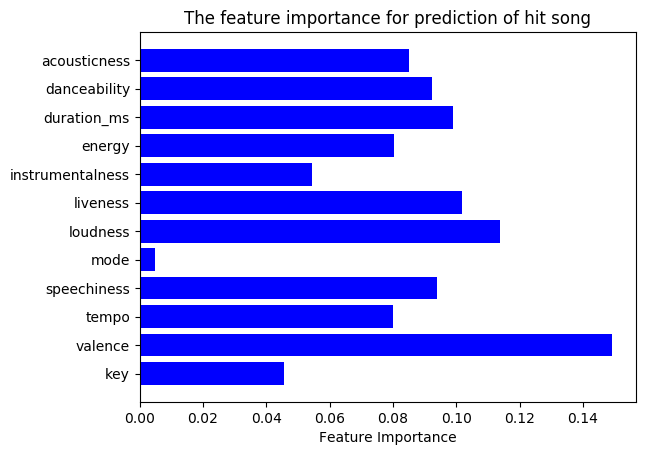

In [59]:
plt.rcdefaults()
fig, ax = plt.subplots()

importance = gbdt.feature_importances_
variable = X.columns.values
x_variable = np.arange(len(variable))

ax.barh(x_variable, importance, color = 'blue', ecolor = 'black')
ax.set_yticks(x_variable)
ax.set_yticklabels(variable)
ax.invert_yaxis()
ax.set_xlabel('Feature Importance')
ax.set_title('The feature importance for prediction of hit song')

plt.show()
plt.gcf().clear()

### 4) Final classifier

In [67]:
tracks_df_up = pd.read_csv('tracks_up_2016.csv')
tracks_df_up = tracks_df_up.sample(frac=1)
X = tracks_df_up[['acousticness', 'danceability', 'duration_ms', 'energy', 
                'instrumentalness', 'liveness', 'loudness', 'mode',
                'speechiness', 'tempo', 'valence', 'key']]
y = tracks_df_up['Class']
gbdt = ensemble.GradientBoostingClassifier(learning_rate = 0.6, n_estimators = 90)
gbdt.fit(X, y)

tracks_df_up = pd.read_csv('tracks_up_2017.csv')
tracks_df_up = tracks_df_up.sample(frac=1)
X_test = tracks_df_up[['acousticness', 'danceability', 'duration_ms', 'energy', 
                'instrumentalness', 'liveness', 'loudness', 'mode',
                'speechiness', 'tempo', 'valence', 'key']]
y_test = tracks_df_up['Class']
y_pred = gbdt.predict(X_test)
f1 = f1_score(y_test, y_pred)
print('Best learning_rate is %.1f, F1: %.4f' % (0.6, f1))

Best learning_rate is 0.6, F1: 0.8972


In [48]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)
f1_lst = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    f1 = f1_score(y_test, pred)
    print('F1: %.4f' % f1)
    f1_lst.append(f1)
np.mean(f1_lst)

F1: 0.5455
F1: 0.2500
F1: 0.7500
F1: 0.6000
F1: 0.5217


0.53343873517786566

### 5. Test
You can test any song you like here.

In [71]:
test_ID, drop_lst = getID(["Look What You Made Me Do"])
test = sp.audio_features(test_ID)[0]
X = pd.Series(test)[['acousticness', 'danceability', 'duration_ms', 'energy', 
                'instrumentalness', 'liveness', 'loudness', 'mode',
                'speechiness', 'tempo', 'valence', 'key']]
gbdt.predict(X)

C:\Users\green\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([1], dtype=int64)